In [24]:
# Relevant Python Libraries  

import pandas as pd                         # for data manupulation                   
import matplotlib.pyplot as plt             # for data visualization
from sklearn.impute import SimpleImputer    # for data impution 
import numpy as np                          # for numeracal computation
from linearmodels.panel import PanelOLS     # for statistical modeling 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad
from scipy import stats
from linearmodels import RandomEffects
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
import numpy as np
from scipy import stats
from linearmodels import PooledOLS


In [12]:
# import data as dataframe for analysis 

df = pd.read_excel('/Users/davidsokurov/Desktop/I.S./Data Analysis/Final I.S. Dataset.xlsx')

The data is processed and analyzed in the following 4 steps:

1. Data cleaning, wrangling and organization 
2. Exploratory Data Analysis (EDA)
3. Regression Modeling and Analysis
4. Regression Diagnostic checks 

#### Step 1. Data cleaning, wrangling and organization 

In [6]:
# Total missing values are 51 (Visitation and Tourism)
missing_values = df.isnull().sum()
print(missing_values)
total_missing_values = df.isnull().sum().sum()

print("Total missing values:", total_missing_values)

Park                    0
Country                 0
Year                    0
Visitation             13
AnimationPopularity     0
GDP                     0
Population              0
Tourism                38
GDPPerCapita            0
dtype: int64
Total missing values: 51


In [ ]:
# Imputes the variables Visitation and Tourism
df['Visitation'] = df.groupby('Park')['Visitation'].transform(lambda x: x.fillna(x.mean()))
df['Tourism'] = df.groupby('Park')['Tourism'].transform(lambda x: x.fillna(x.mean()))

In [7]:
# Get the list of variables 
variable_list = df.columns.tolist()
print("List of variables:", variable_list)

List of variables: ['Park', 'Country', 'Year', 'Visitation', 'AnimationPopularity', 'GDP', 'Population', 'Tourism', 'GDPPerCapita']


In [8]:
unique_parks = df['Park'].unique()
unique_park_count = df['Park'].nunique()
print(unique_park_count)
print(unique_parks)

19
['Universal Studios Orlando ' 'Universal Studios Hollywood '
 'Magic Kingdom' 'Epcot (Walt Disney World) ' 'Disneyland Anaheim '
 "Disney's California Adventure " "Disney's Animal Kingdom "
 'Lotte World South Korea' 'Everland South Korea'
 'Efteling Theme Park Resort the Netherlands' 'Universal Studios Japan'
 'Tokyo DisneySea Japan' 'Tokyo Disneyland Japan'
 'Nagashima Spa Land Japan' 'Ocean Park Hong Kong S.A.R.'
 'Hong Kong Disneyland Hong Kong S.A.R.' 'Europa-Park Germany'
 'Walt Disney Studios Park France' 'Disneyland Park France']


In [9]:
# GIves the list of all missing values and their locations 
missing_values_df = df.isnull()

missing_locations = pd.DataFrame([(row, col) for row in missing_values_df.index for col in missing_values_df.columns if missing_values_df.at[row, col]])
print("Locations of missing values:")
print(missing_locations)

Locations of missing values:
      0           1
0     0     Tourism
1     1     Tourism
2    19     Tourism
3    20     Tourism
4    38     Tourism
5    39     Tourism
6    57     Tourism
7    58     Tourism
8    76     Tourism
9    77     Tourism
10   95     Tourism
11   96     Tourism
12  114     Tourism
13  115     Tourism
14  133     Tourism
15  134     Tourism
16  139  Visitation
17  141  Visitation
18  147  Visitation
19  148  Visitation
20  149  Visitation
21  150  Visitation
22  152     Tourism
23  153     Tourism
24  171     Tourism
25  172     Tourism
26  190     Tourism
27  191     Tourism
28  209     Tourism
29  210     Tourism
30  228     Tourism
31  229     Tourism
32  247     Tourism
33  248     Tourism
34  253  Visitation
35  255  Visitation
36  256  Visitation
37  266     Tourism
38  267     Tourism
39  285     Tourism
40  286     Tourism
41  302  Visitation
42  303  Visitation
43  304     Tourism
44  305     Tourism
45  323     Tourism
46  324     Tourism
47  340  Vi

In [10]:
# Saves the new dataset as a csv file
df.to_csv("final_data.csv", index=False)
#df.to_excel("edited_dataset.xlsx")

In [13]:
unique_countries = df["Country"].unique()
print(unique_countries)

['USA' 'South Korea' 'Netherlands' 'Japan' 'Hong Kong' 'Germany' 'France']


#### Step 2. Exploratory Data Analysis 

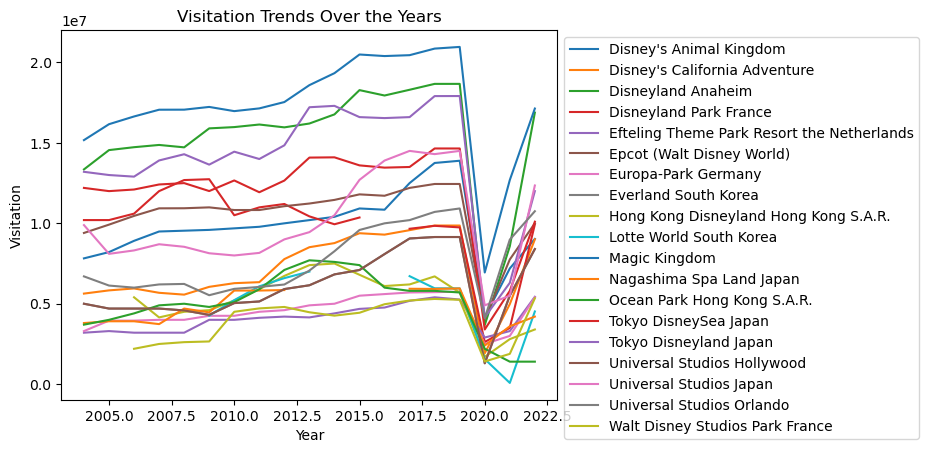

<Figure size 1500x600 with 0 Axes>

In [14]:
for park, data in df.groupby('Park'):
    plt.plot(data['Year'], data['Visitation'], label=park)

plt.title('Visitation Trends Over the Years')
plt.xlabel('Year')
plt.ylabel('Visitation')

# Create a separate legend object
legend = plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.figure(figsize=(15, 6))  

plt.show()

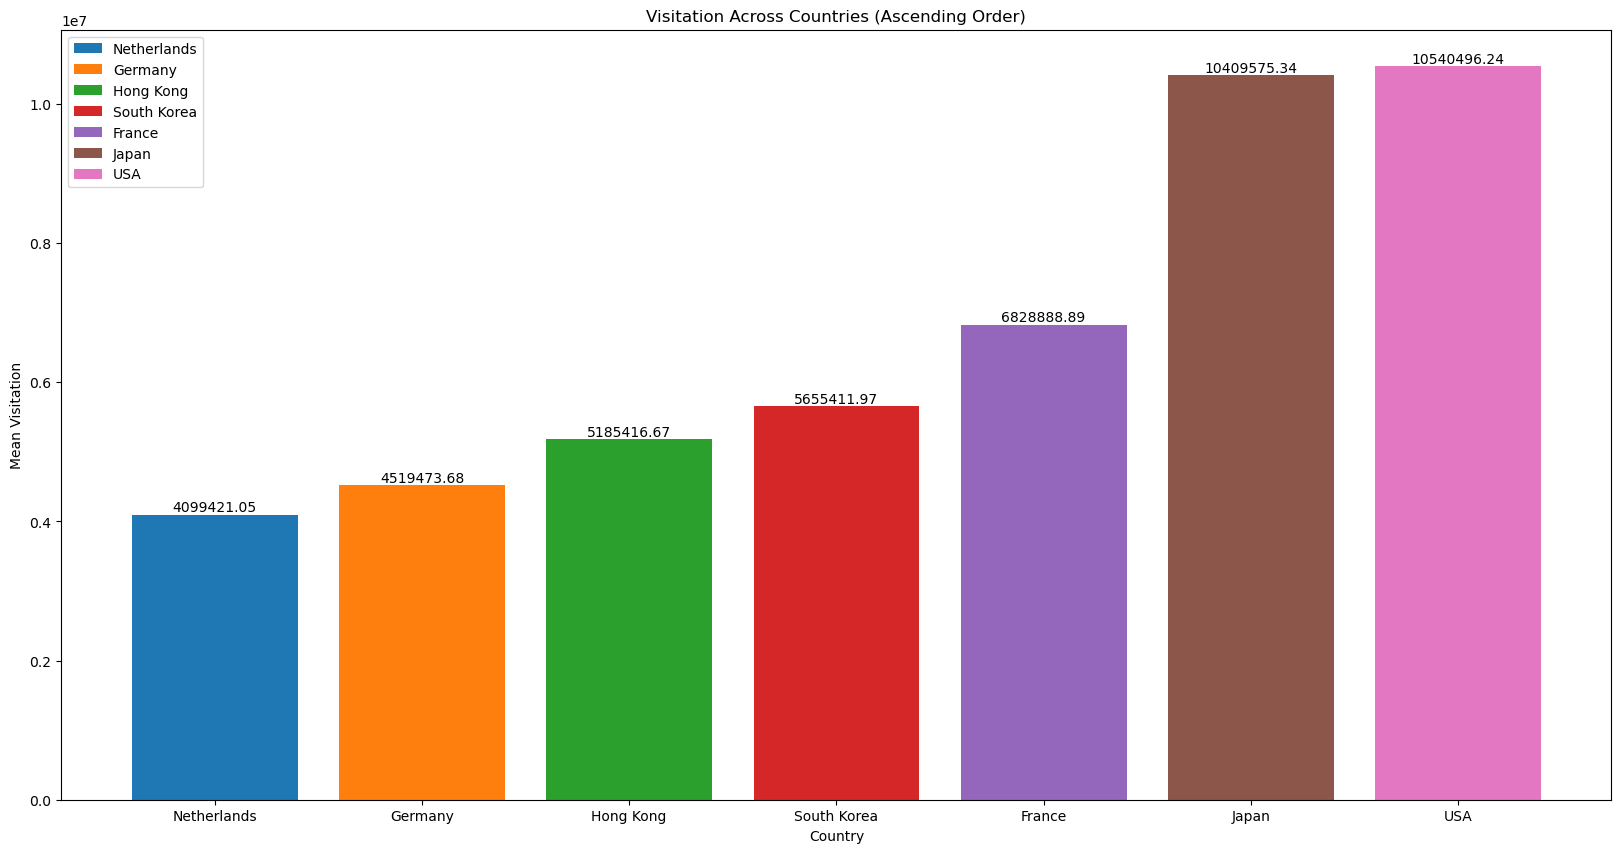

In [15]:
# add numbers on bargraphs 
mean_visitation_by_country = df.groupby('Country')['Visitation'].mean()

# Sort countries in ascending order based on mean visitation
sorted_countries = mean_visitation_by_country.sort_values().index

plt.figure(figsize=(20, 10))
for country in sorted_countries:
    plt.bar(country, mean_visitation_by_country[country], label=country)
    plt.text(country, mean_visitation_by_country[country], f'{mean_visitation_by_country[country]:.2f}', ha='center', va='bottom')

plt.title('Visitation Across Countries (Ascending Order)')
plt.xlabel('Country')
plt.ylabel('Mean Visitation')
plt.legend()
plt.show()

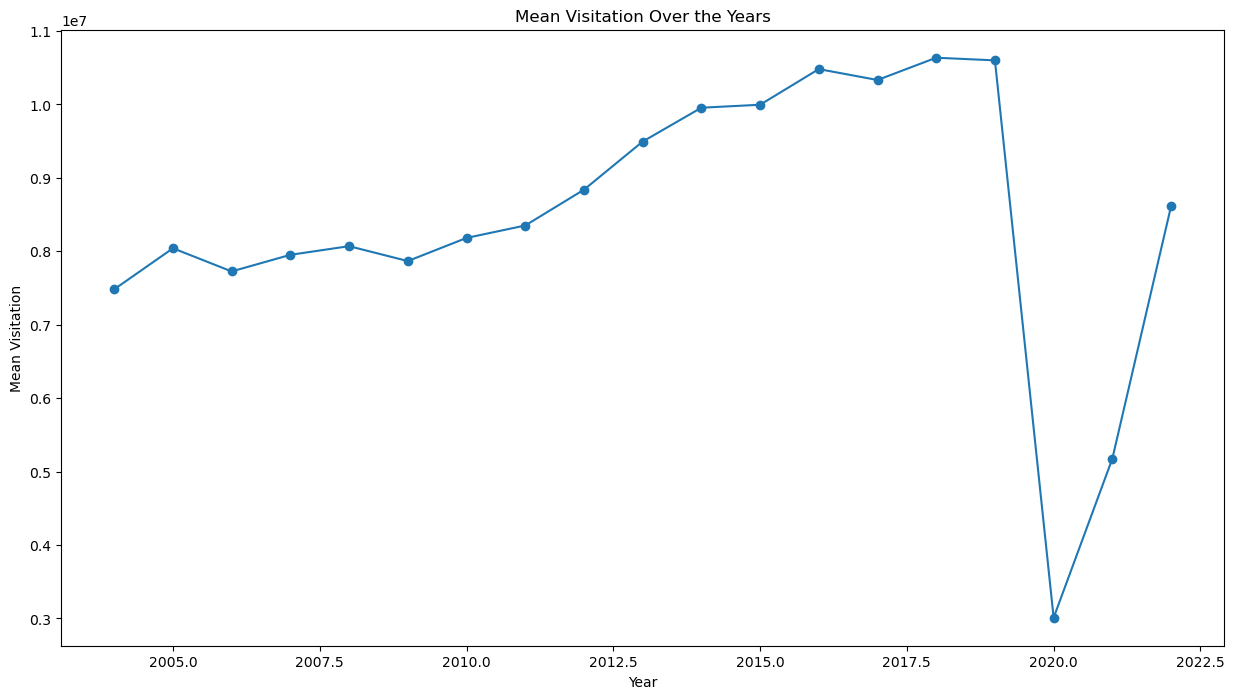

In [16]:
plt.figure(figsize=(15, 8))
df.groupby('Year')['Visitation'].mean().plot(marker='o')
plt.title('Mean Visitation Over the Years')
plt.xlabel('Year')
plt.ylabel('Mean Visitation')
plt.show()

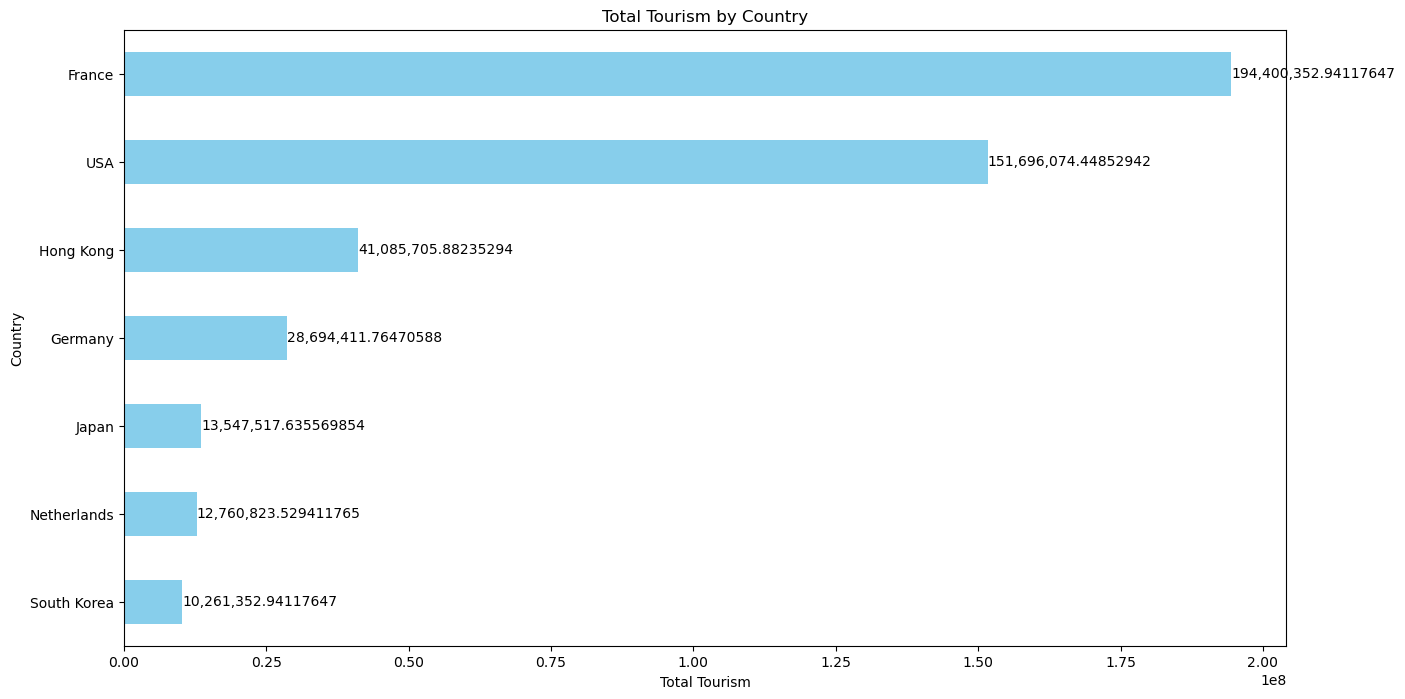

In [17]:
# MAKE IT HORIZONTAL
plt.figure(figsize=(15, 8))
tourism_by_country = df.groupby('Country')['Tourism'].mean().sort_values(ascending=True)
tourism_by_country.plot(kind='barh', color='skyblue')

for index, value in enumerate(tourism_by_country):
    plt.text(value, index, f'{value:,}', va='center', fontsize=10)

plt.title('Total Tourism by Country')
plt.xlabel('Total Tourism')
plt.ylabel('Country')
plt.show()

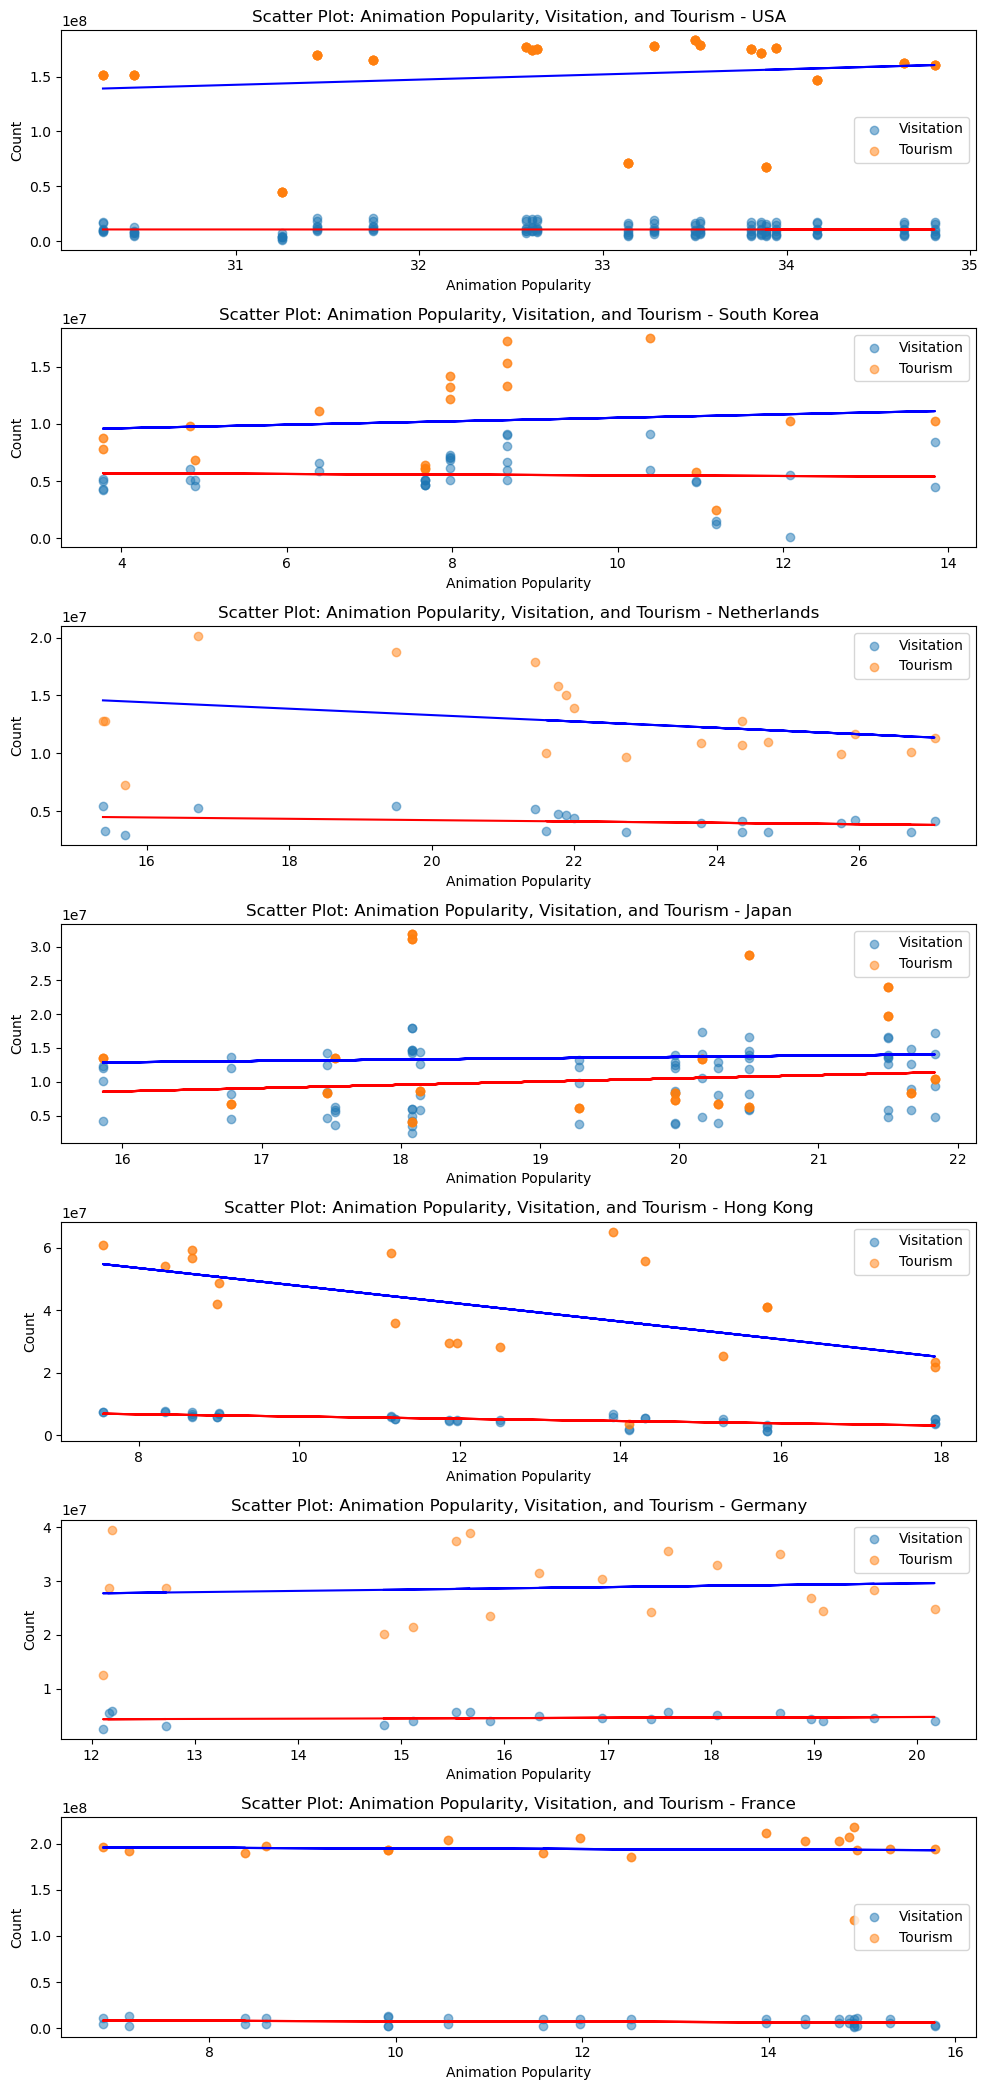

In [34]:
# Get the list of unique countries
countries = df['Country'].unique()

# Create subplots for each country
fig, axes = plt.subplots(nrows=len(countries), ncols=1, figsize=(10, 3 * len(countries)))

# Iterate over countries and create scatter plots with trend lines
for i, country in enumerate(countries):
    country_data = df[df['Country'] == country]
    
    # Scatter Plot: Animation Popularity vs. Visitation
    axes[i].scatter(x='AnimationPopularity', y='Visitation', data=country_data, alpha=0.5, label='Visitation')
    
    # Trend line for Animation Popularity vs. Visitation
    z_visitation = np.polyfit(country_data['AnimationPopularity'], country_data['Visitation'], 1)
    p_visitation = np.poly1d(z_visitation)
    axes[i].plot(country_data['AnimationPopularity'], p_visitation(country_data['AnimationPopularity']), color='red')

    # Scatter Plot: Animation Popularity vs. Tourism
    axes[i].scatter(x='AnimationPopularity', y='Tourism', data=country_data, alpha=0.5, label='Tourism')
    
    # Trend line for Animation Popularity vs. Tourism
    z_tourism = np.polyfit(country_data['AnimationPopularity'], country_data['Tourism'], 1)
    p_tourism = np.poly1d(z_tourism)
    axes[i].plot(country_data['AnimationPopularity'], p_tourism(country_data['AnimationPopularity']), color='blue')

    axes[i].set_title(f'Scatter Plot: Animation Popularity, Visitation, and Tourism - {country}')
    axes[i].set_xlabel('Animation Popularity')
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.tight_layout()
plt.show()


#### Step 3. Regression

In [19]:
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

# Set the DataFrame index using the panel variables and sort it
df.set_index(['Park', 'Year'], inplace=True)
df.sort_index(inplace=True)

# Create a PanelOLS model
model = PanelOLS.from_formula('Visitation ~ AnimationPopularity + Tourism + GDP + Population', data=df)

# Fit the model
result = model.fit()

# Print regression results
print(result)

                          PanelOLS Estimation Summary                           
Dep. Variable:             Visitation   R-squared:                        0.0144
Estimator:                   PanelOLS   R-squared (Between):              0.0946
No. Observations:                 310   R-squared (Within):              -0.2405
Date:                Fri, Apr 05 2024   R-squared (Overall):              0.0144
Time:                        22:20:10   Log-likelihood                   -5193.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.4907
Entities:                          19   P-value                           0.2171
Avg Obs:                       16.316   Distribution:                   F(3,306)
Min Obs:                       11.000                                           
Max Obs:                       17.000   F-statistic (robust):             4.9642
                            

/opt/anaconda3/lib/python3.11/site-packages/linearmodels/panel/model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


#### Step 4. Diagnostics Checks and Adjusting the Model 

In [20]:
df = pd.read_excel('/Users/davidsokurov/Desktop/I.S./Data Analysis/Final I.S. Dataset.xlsx')
df.set_index(["Park", "Year"], inplace=True)


df['Visitation'] = df.groupby('Park')['Visitation'].transform(lambda x: x.fillna(x.mean()))
df['Tourism'] = df.groupby('Park')['Tourism'].transform(lambda x: x.fillna(x.mean()))

In [21]:
years = df.index.get_level_values("Year").to_list()
df["Year"] = pd.Categorical(years)

In [22]:
correlation_matrix = df[["AnimationPopularity", "Tourism", "GDP", "Population"]].corr()
print(correlation_matrix)


                     AnimationPopularity   Tourism       GDP  Population
AnimationPopularity             1.000000  0.496776  0.864348    0.907741
Tourism                         0.496776  1.000000  0.599833    0.590237
GDP                             0.864348  0.599833  1.000000    0.968551
Population                      0.907741  0.590237  0.968551    1.000000


In [25]:
# Perform PooledOLS
exog = sm.tools.tools.add_constant(df["AnimationPopularity"])

endog = df["Visitation"]
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

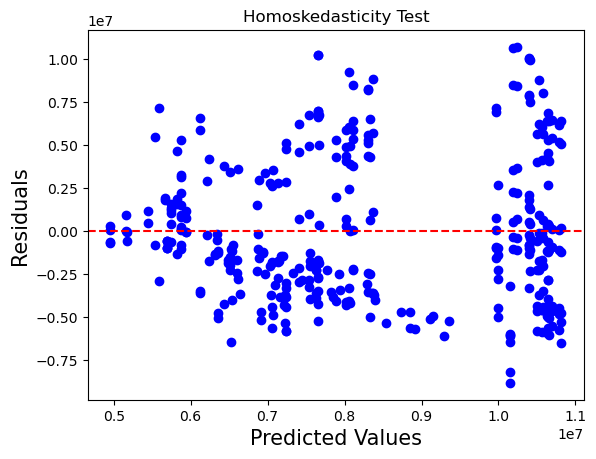

In [26]:
# 3A. Homoskedasticity

 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = "blue")
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel("Predicted Values", fontsize = 15)
ax.set_ylabel("Residuals", fontsize = 15)
ax.set_title("Homoskedasticity Test", fontsize = 12)
plt.show()

In [27]:
# 3A.2 White-Test

# Assuming you have residuals_pooled_OLS from your previous code
pooled_OLS_dataset = pd.concat([df, residuals_pooled_OLS.rename("residuals")], axis=1)
pooled_OLS_dataset = pooled_OLS_dataset.drop(["Year"], axis=1).fillna(0)
exog = sm.tools.tools.add_constant(df["AnimationPopularity"]).fillna(0)
white_test_results = het_white(pooled_OLS_dataset["residuals"], exog)
labels = ["LM-Stat", "LM p-val", "F-Stat", "F p-val"] 
print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset["residuals"], exog)
labels = ["LM-Stat", "LM p-val", "F-Stat", "F p-val"] 
print(dict(zip(labels, breusch_pagan_test_results)))


{'LM-Stat': 34.991710772519376, 'LM p-val': 2.5214278739225677e-08, 'F-Stat': 19.21275143991949, 'F p-val': 1.1861453597997972e-08}
{'LM-Stat': 25.34038880235893, 'LM p-val': 4.805407552463173e-07, 'F-Stat': 27.102455215233793, 'F p-val': 3.255283000339051e-07}


In summary, the statistical tests indicate that the assumption of homoskedasticity is likely violated, and there is evidence to support the presence of heteroskedasticity in the residuals.

In [28]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset["residuals"]) 
print(durbin_watson_test_results)

0.4085650375729621


Durbin-Watson statistic of 0.41 is significantly less than 2, indicating positive autocorrelation in the residuals. This suggests that there may be a pattern in the residuals that is not explained by the model, and there might be some temporal dependence between consecutive observations.

As a consequence, assumption 3b is also violated, so it seems that a FE-/RE-model will be more suitable.

In [29]:
# Assuming df contains 'AnimationPopularity', 'Tourism', 'GDP', 'Population', and 'Visitation'
exog_vars = ['AnimationPopularity', 'Tourism', 'Population']
exog = sm.tools.tools.add_constant(df[exog_vars])
endog = df['Visitation']

# Random effects model
model_re = RandomEffects(endog, exog, check_rank=False) 
re_res = model_re.fit() 

# Fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects=True) 
fe_res = model_fe.fit() 

# Print results
print(re_res)


                        RandomEffects Estimation Summary                        
Dep. Variable:             Visitation   R-squared:                        0.2600
Estimator:              RandomEffects   R-squared (Between):             -0.1824
No. Observations:                 361   R-squared (Within):               0.2800
Date:                Fri, Apr 05 2024   R-squared (Overall):             -0.0693
Time:                        22:21:49   Log-likelihood                   -5744.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      41.808
Entities:                          19   P-value                           0.0000
Avg Obs:                       19.000   Distribution:                   F(3,357)
Min Obs:                       19.000                                           
Max Obs:                       19.000   F-statistic (robust):             41.808
                            

In [30]:
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:             Visitation   R-squared:                        0.2815
Estimator:                   PanelOLS   R-squared (Between):             -0.2548
No. Observations:                 361   R-squared (Within):               0.2815
Date:                Fri, Apr 05 2024   R-squared (Overall):             -0.1237
Time:                        22:21:49   Log-likelihood                   -5731.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      44.280
Entities:                          19   P-value                           0.0000
Avg Obs:                       19.000   Distribution:                   F(3,339)
Min Obs:                       19.000                                           
Max Obs:                       19.000   F-statistic (robust):             44.280
                            

In [31]:
# Log transformation of the dependent variable
df['Log_Visitation'] = np.log(df['Visitation'])

# Define independent and dependent variables
X = df[['AnimationPopularity', 'Tourism', 'GDPPerCapita',]]
y = df['Log_Visitation']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

# Test for multicollinearity
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

print("\nVariance Inflation Factor (VIF):")
print(calculate_vif(X))

# Test for homoskedasticity
_, p_homoskedasticity, _, _ = het_breuschpagan(model.resid, X)
print("\nHomoskedasticity Test (Breusch-Pagan):")
print("p-value:", p_homoskedasticity)

# Test for normality of residuals
p_normality = stats.normaltest(model.resid)[1]
print("\nNormality Test (Jarque-Bera):")
print("p-value:", p_normality)

                            OLS Regression Results                            
Dep. Variable:         Log_Visitation   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     22.17
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           3.45e-13
Time:                        22:21:54   Log-Likelihood:                -307.91
No. Observations:                 361   AIC:                             623.8
Df Residuals:                     357   BIC:                             639.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  15.3715    

In [33]:
# Log transformation of the dependent variable
df['Log_Visitation'] = np.log(df['Visitation'])

# Log transformation of independent variables
df['Log_Tourism'] = np.log(df['Tourism'])
df['Log_GDPPerCapita'] = np.log(df['GDPPerCapita'])

# Define independent and dependent variables
X = df[['AnimationPopularity', 'Log_Tourism', 'Log_GDPPerCapita']]
y = df['Log_Visitation']

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression results
print(model.summary())

# Test for multicollinearity
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

print("\nVariance Inflation Factor (VIF):")
print(calculate_vif(X))

# Test for homoskedasticity
_, p_homoskedasticity, _, _ = het_breuschpagan(model.resid, X)
print("\nHomoskedasticity Test (Breusch-Pagan):")
print("p-value:", p_homoskedasticity)

# Test for normality of residuals
p_normality = stats.normaltest(model.resid)[1]
print("\nNormality Test (Jarque-Bera):")
print("p-value:", p_normality)

                            OLS Regression Results                            
Dep. Variable:         Log_Visitation   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     21.96
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           4.49e-13
Time:                        22:21:59   Log-Likelihood:                -308.18
No. Observations:                 361   AIC:                             624.4
Df Residuals:                     357   BIC:                             639.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  16.2131    